In [1]:
import os 
import numpy as np
import tensorflow as tf
import splitfolders
import matplotlib.pyplot as plt
import cv2

In [41]:
splitfolders.ratio("./Segmented Medicinal Leaf Images", output="output",
    seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=True)

Copying files: 0 files [00:00, ? files/s]


In [2]:
train_path = "./output/train"
val_path = "./output/val"
test_path = "./output/test"

In [3]:
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr = cv2.imread(image_path)
        
        img_arr = cv2.resize(img_arr, (224,224))
        
        x_train.append(img_arr)

In [4]:
x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)

In [5]:
x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)

In [6]:
train_x = np.array(x_train)
test_x = np.array(x_test)
val_x = np.array(x_val)

In [7]:
train_x = train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1089 images belonging to 30 classes.
Found 390 images belonging to 30 classes.
Found 356 images belonging to 30 classes.


In [10]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [32]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19

In [33]:
vgg19 = VGG19(include_top=False,
              weights='imagenet',
              input_shape=[224,224] + [3],
             )

In [34]:
for layer in vgg19.layers:
    layer.trainable=False

In [35]:
x = Flatten()(vgg19.output)

In [36]:
prediction = Dense(30, activation='softmax')(x)
model = Model(inputs=vgg19.input, outputs=prediction)

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
early_stops=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [39]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stops],
  batch_size=32,shuffle=True)

Epoch 1/10
35/35 [==============================] - 362s 10s/step - loss: 1.8786 - accuracy: 0.5638 - val_loss: 0.5237 - val_accuracy: 0.8399
Epoch 2/10
35/35 [==============================] - 343s 10s/step - loss: 0.1967 - accuracy: 0.9458 - val_loss: 0.3139 - val_accuracy: 0.9073
Epoch 3/10
35/35 [==============================] - 339s 10s/step - loss: 0.3972 - accuracy: 0.9412 - val_loss: 0.2535 - val_accuracy: 0.9438
Epoch 4/10
35/35 [==============================] - 346s 10s/step - loss: 0.0490 - accuracy: 0.9899 - val_loss: 0.2048 - val_accuracy: 0.9382
Epoch 5/10
35/35 [==============================] - 337s 10s/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.1769 - val_accuracy: 0.9579
Epoch 6/10
35/35 [==============================] - 340s 10s/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.1702 - val_accuracy: 0.9438
Epoch 7/10
35/35 [==============================] - 337s 10s/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1605 - val_accuracy: 0.9494
Epoch 

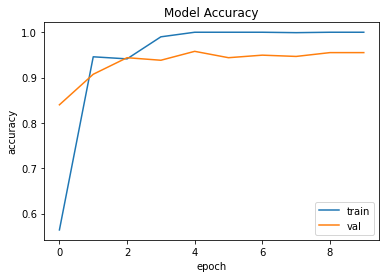

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='lower right')
plt.show()

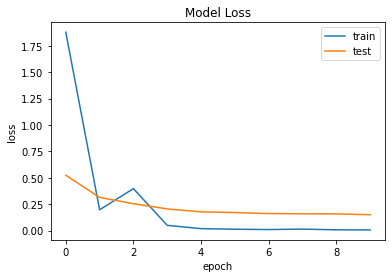

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

In [49]:
test_loss, test_acc = model.evaluate(test_x,  test_y, verbose=2)

13/13 - 87s - loss: 0.1532 - accuracy: 0.9590 - 87s/epoch - 7s/step
